# Forecasting Methodology

## **Methodology:**  
Exogenous Time Series Forecasting with ARIMA and SARIMAX.  
This approach involves leveraging historical data to predict the future behavior of a target variable while incorporating exogenous features to improve model accuracy.

---

## **Data Division**
- **Split the Dataset:**
    - Divide the dataset into training and testing sets based on a `train_size` parameter.
    - Ensure the test set is reserved for out-of-sample evaluation.

---

## **ARIMA Modeling**
1. **Automatic Order Selection:**
    - Use `auto_arima` to automatically determine the optimal `(p, d, q)` parameters for the ARIMA model.
    - Include exogenous variables for better modeling of the target variable.

2. **Model Training:**
    - Fit a SARIMAX (Seasonal ARIMA with Exogenous Variables) model to the training data using the selected parameters.
    - Incorporate relevant exogenous features identified during data preprocessing.

---

## **Predictions and Assessment**
1. **Generate Predictions:**
    - Predict values for the training and test datasets using the trained SARIMAX model.
    - Optionally, generate predictions for future time steps based on provided exogenous forecasts.

2. **Evaluate Performance:**
    - Compute key performance metrics:
        - **MSE** (Mean Squared Error)
        - **RMSE** (Root Mean Squared Error)
        - **MAE** (Mean Absolute Error)
        - **R²** (Coefficient of Determination)

---

## **Exogenous Variable Prediction**
1. **Optimal Lags Selection:**
    - Determine the most significant lag for each exogenous variable using `auto_arima` or correlation analysis.
    - Add these lagged variables as features to the dataset.

2. **Exogenous Forecasting:**
    - Train machine learning models or ARIMA models for predicting exogenous variables.
    - Use methods like GridSearchCV or auto_arima to select the best-performing model based on metrics like MSE.

3. **Future Exogenous Forecasts:**
    - Predict future values of the exogenous variables to serve as inputs for forecasting the target variable.

---

## **Future Forecast**
- Generate multi-step forecasts of the target variable by leveraging future predictions of exogenous features and extending the SARIMAX model.

---

## **Visualization**
- **Training and Testing Performance:**
    - Plot actual vs. predicted values for both training and test datasets.
    - Overlay predictions on the original time series to visualize the model’s accuracy.

- **Future Forecast:**
    - If applicable, visualize forecasts for the target variable over the desired time horizon using the predicted exogenous inputs.


# Importar bibliotecas necessárias

In [1]:
import os
import pandas as pd
from tsSarimax.models.predictor import ARIMAPredictor
from tsSarimax.utils.data_preprocessor import DataPreprocessor
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Carregar os dados

In [2]:
data_dir = './tsSarimax/datasets'
data_file = os.path.join(data_dir, 'day.csv')
data = pd.read_csv(data_file)

# Pré-processamento dos dados

In [3]:
data['dteday'] = pd.to_datetime(data['dteday'])
# Extrair características de data
data['year'] = data['dteday'].dt.year
data['month'] = data['dteday'].dt.month
data['day'] = data['dteday'].dt.day
data['dayofweek'] = data['dteday'].dt.dayofweek
data.drop('dteday', axis=1, inplace=True)

preprocessor = DataPreprocessor(data, target_col='cnt')
data = preprocessor.preprocess(scale_numeric=True, drop_first=True)

# Selecionar colunas com base na correlação

In [4]:
threshold_min = 0.5
threshold_max = 0.9
target_col = 'cnt'  # Substitua pelo nome da variável alvo, se necessário

dummies_cols, _ = preprocessor.get_processed_columns()

data_for_correlation = data.drop(columns=dummies_cols)
correlation_matrix = data_for_correlation.corr()

selected_columns = correlation_matrix.index[
    (abs(correlation_matrix[target_col]) >= threshold_min) & (abs(correlation_matrix[target_col]) <= threshold_max)
].tolist()

if target_col not in selected_columns:
    selected_columns.append(target_col)

filtered_data = data[selected_columns + dummies_cols]

# Separar os dados em treino e validação

In [5]:
total_observations = len(filtered_data)
validation_size = int(0.1 * total_observations)
validation_start_index = total_observations - validation_size

train_data = filtered_data.iloc[:validation_start_index]
validation_data = filtered_data.iloc[validation_start_index:]

# Usando a classe ARIMAPredictor
Inicializar a classe com os dados de treinamento

In [6]:
predictor = ARIMAPredictor(train_data, target_col)

# Escolher colunas exógenas (excluindo a variável-alvo e mantendo dummies)
feature_cols = [col for col in filtered_data.columns if col != target_col]

# Executar previsões com SARIMAX

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9715.391, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9650.502, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9553.328, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9713.454, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9518.984, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9519.966, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9520.180, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9519.199, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9614.697, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9520.562, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.623 seconds


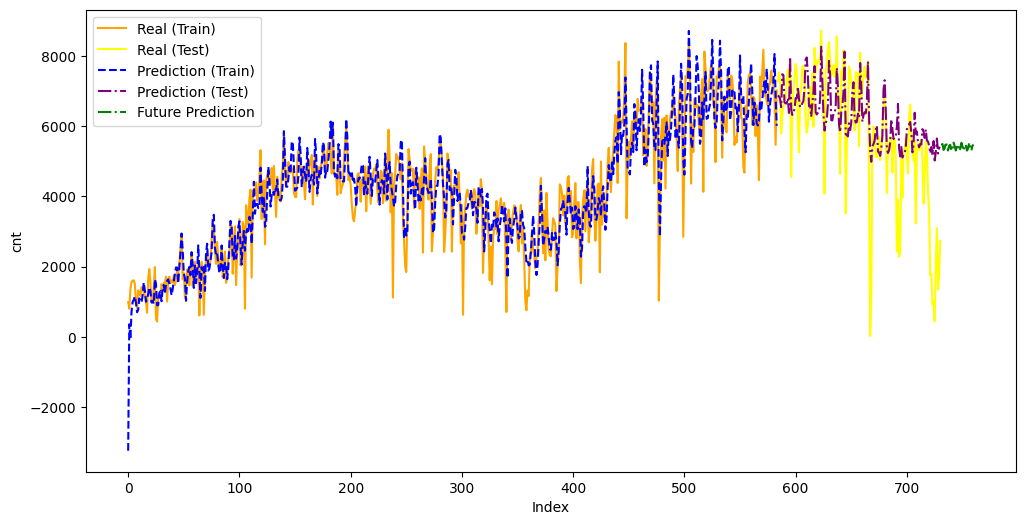

In [ ]:
# Inicializar a instância com os dados
predictor = ARIMAPredictor(data, target_col=target_col)

# Treinar e obter o modelo ajustado com SARIMAX
train_preds, test_preds, future_preds, model_fit, train_metrics, test_metrics = predictor.train_and_predict_sarimax(
    feature_cols=feature_cols,
    seasonal=False,
    stepwise=True,
    forecast_horizon=30  # Número de passos futuros para testar
)

# Exibir resultados

In [14]:
print("Train Metrics:")
print(f"  Mean Squared Error (MSE): {train_metrics[0]:.4f}")
print(f"  Root Mean Squared Error (RMSE): {train_metrics[1]:.4f}")
print(f"  Mean Absolute Error (MAE): {train_metrics[2]:.4f}")
print(f"  R-squared (R2): {train_metrics[3]:.4f}")
print(f"  Combined Score: {train_metrics[4]:.4f}")

print("Test Metrics:")
print(f"  Mean Squared Error (MSE): {test_metrics[0]:.4f}")
print(f"  Root Mean Squared Error (RMSE): {test_metrics[1]:.4f}")
print(f"  Mean Absolute Error (MAE): {test_metrics[2]:.4f}")
print(f"  R-squared (R2): {test_metrics[3]:.4f}")
print(f"  Combined Score: {test_metrics[4]:.4f}")

Train Metrics:
  Mean Squared Error (MSE): 509453.1841
  Root Mean Squared Error (RMSE): 713.7599
  Mean Absolute Error (MAE): 543.0022
  R-squared (R2): 0.8405
  Combined Score: 127677.5264
Test Metrics:
  Mean Squared Error (MSE): 2299596.0497
  Root Mean Squared Error (RMSE): 1516.4419
  Mean Absolute Error (MAE): 1084.7690
  R-squared (R2): 0.3456
  Combined Score: 575549.4787


# Previsões futuras

In [12]:
print(f"Future Predictions: {future_preds}")

Future Predictions: 584    5469.210083
585    5487.166260
586    5319.327302
587    5372.654380
588    5537.459676
589    5423.824571
590    5302.031936
591    5440.505416
592    5465.204858
593    5297.214744
594    5356.716483
595    5527.050485
596    5419.197581
597    5303.059745
598    5442.605704
599    5466.290955
600    5299.274606
601    5357.948720
602    5524.438618
603    5416.137483
604    5303.278098
605    5443.747682
606    5466.917769
607    5301.262118
608    5359.308125
609    5522.078796
610    5413.338471
611    5303.599712
612    5444.793084
613    5467.346096
Name: predicted_mean, dtype: float64
